In [10]:
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
#定义网络结构
class Net(nn.Module):
    def __init__(self, in_c, out_c):
        super(Net, self).__init__()
        
        # 定义全连接层
        self.fc1 = nn.Linear(in_c, 512)
        # 定义激活层
        self.act1 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(256, 128)
        self.act3 = nn.ReLU(inplace=True)

        self.fc4 = nn.Linear(128, out_c)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x 

# 构建网络
net = Net(784, 10)
summary(net)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            401,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            131,328
├─ReLU: 1-4                              --
├─Linear: 1-5                            32,896
├─ReLU: 1-6                              --
├─Linear: 1-7                            1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0

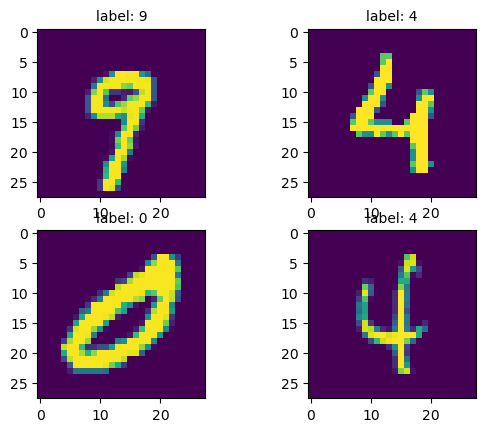

In [4]:
# 准备数据集
# 训练集
train_set = mnist.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
# 测试集
test_set = mnist.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)
# 训练集载入器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 测试集载入器
test_data = DataLoader(test_set, batch_size=128, shuffle=False) 

# 可视化数据
import random
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    idx = random.randint(0, len(train_set))
    digit_0 = train_set[idx][0].numpy()
    digit_0_image = digit_0.reshape(28, 28)
    ax.imshow(digit_0_image, interpolation="nearest")
    ax.set_title('label: {}'.format(train_set[idx][1]), fontsize=10, color='black')
plt.show()

In [5]:
# 定义损失函数--交叉熵
criterion = nn.CrossEntropyLoss()

# 定义优化器---随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=5e-4)

In [32]:
train_set[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [37]:
for batch, (img, label) in enumerate(train_data):
    if batch == 0:
        img = img.reshape(img.size(0), -1)
        print (img[0])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1961, 0.7490, 0.2941, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
# 开始训练
# 记录训练损失
losses = []
# 记录训练精度
acces = []
# 记录测试损失
eval_losses = []
# 记录测试精度
eval_acces = []
# 设置迭代次数
nums_epoch = 2
for epoch in range(nums_epoch):
    train_loss = 0
    train_acc = 0
    net = net.train()
    for batch, (img, label) in enumerate(train_data):
        
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        # 前向传播
        out = net(img)
        print (out)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        if (batch + 1) % 200 == 0:
            print('[INFO] Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}'.format(epoch + 1,
                                                                                 batch+1,
                                                                                 loss.item(),
                                                                                 acc))
        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

    eval_loss = 0
    eval_acc = 0
    # 测试集不训练
    for img, label in test_data:
        img = img.reshape(img.size(0),-1)
        img = Variable(img)
        label = Variable(label)

        out = net(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()

        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print('[INFO] Epoch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f} | Test: Loss-{:.4f}, Accuracy-{:.4f}'.format(
        epoch + 1, train_loss / len(train_data), train_acc / len(train_data), eval_loss / len(test_data),
        eval_acc / len(test_data))) 

tensor([[-6.7411e+00,  3.9118e+00,  1.4343e+00,  2.6509e+00, -4.3502e+00,
         -1.4773e+00, -5.9152e+00,  4.4498e+00,  1.6503e+00,  1.6128e+00],
        [-4.0125e+00, -4.5678e+00, -5.7081e+00, -8.9307e-01,  6.0665e+00,
          2.3670e+00, -2.9156e+00,  1.9081e+00,  5.0116e-01,  4.8115e+00],
        [-1.1073e+00, -4.6751e+00, -3.1462e+00, -1.6396e+00,  6.3624e-01,
          6.9630e-01, -5.4499e+00,  7.7414e+00,  5.7634e-02,  4.8038e+00],
        [-2.9375e-01, -3.5248e+00,  2.1821e+00, -2.7115e+00,  2.3409e+00,
          1.1463e+00,  7.3422e+00, -5.2793e+00,  9.8010e-01, -2.7408e+00],
        [ 2.0767e+00, -6.0076e+00, -1.5405e+00, -2.3934e+00,  6.2839e-01,
          3.6129e+00,  6.2318e-01, -4.0696e-01,  1.3931e+00,  7.6036e-01],
        [-5.2660e+00, -2.4706e+00,  3.7060e+00, -1.2218e+00,  3.4583e+00,
          1.8183e+00,  9.4437e+00, -1.1014e+01,  3.7332e+00, -4.1176e+00],
        [ 3.6628e+00, -6.2273e+00, -4.6884e+00,  4.0123e+00, -4.0635e+00,
          9.0158e+00, -6.0496e+0

tensor([[ 1.2575e-01, -3.4880e+00,  2.0873e+00,  1.0323e+00, -2.5828e-01,
          3.5654e+00,  6.3008e+00, -8.0597e+00,  2.0898e+00, -4.1169e+00],
        [-5.9722e+00, -5.7517e+00, -5.2827e+00, -5.3432e+00,  8.1544e+00,
          1.8730e+00,  2.6395e-01, -1.5172e+00,  4.2961e+00,  5.7848e+00],
        [-6.9003e-01, -8.8870e+00,  7.6102e+00, -4.9859e+00,  5.1603e+00,
         -6.3849e-01,  1.5215e+01, -1.0166e+01,  1.5909e+00, -4.9819e+00],
        [-1.0487e+01,  8.0079e+00,  2.4559e+00,  2.9162e+00, -4.6694e+00,
         -1.5999e+00, -3.8305e+00,  2.3802e+00,  2.0406e+00, -3.0372e-01],
        [-4.6813e-01, -6.6662e+00,  3.6343e+00, -2.9291e+00,  2.5546e+00,
          1.2339e+00,  9.0788e+00, -7.5895e+00,  2.3508e+00, -2.4681e+00],
        [-5.7307e+00,  5.3627e+00,  1.1717e+00,  1.0232e+00, -2.7014e+00,
         -4.7716e-01, -1.9695e+00,  8.6007e-01,  1.4782e+00, -7.0513e-01],
        [-4.4526e+00, -4.2521e+00, -3.8731e+00, -1.0778e+00,  4.2787e+00,
          4.5252e-01, -3.9527e+0

tensor([[-5.8359e+00, -6.4522e-01,  5.0470e+00, -1.1720e+00,  1.0477e+00,
         -3.8675e+00,  1.8102e+00, -6.5069e-01,  1.0346e+00,  1.0148e+00],
        [-2.5033e+00, -4.6190e+00,  1.2151e+01,  6.0746e+00, -3.2790e+00,
         -1.9002e+00,  3.2519e+00, -9.3767e+00,  3.0559e+00, -4.1104e+00],
        [-5.4028e-01, -3.4018e+00,  1.9843e+00,  1.0059e+01, -6.2906e+00,
          3.6976e+00, -7.2461e+00, -1.9167e+00,  2.0561e+00,  3.6305e-01],
        [-4.9170e+00, -3.0247e+00, -5.4317e-01, -3.9130e+00,  6.7130e+00,
         -2.1163e+00,  1.1408e+00,  1.5190e-01,  4.6145e-01,  4.0035e+00],
        [ 4.1319e-01, -5.8936e+00,  3.8238e+00,  6.3241e+00, -4.9927e+00,
          3.6174e-01, -5.3325e+00,  1.1720e+00,  9.8143e-01,  1.6134e+00],
        [ 1.2954e+00, -5.1657e+00,  3.2724e+00, -2.4548e+00,  8.1986e-01,
          3.2442e+00,  7.7299e+00, -9.5362e+00,  3.8896e+00, -3.9195e+00],
        [-8.5849e-01, -2.8703e+00,  1.8287e+00,  9.4413e+00, -5.9968e+00,
          3.5653e+00, -7.8191e+0

tensor([[-8.6426e+00,  7.1159e+00,  1.0489e+00,  1.5264e+00, -3.4635e+00,
         -1.1242e+00, -3.4121e+00,  2.4824e+00,  1.7109e+00,  3.5169e-02],
        [ 1.1360e+00, -4.0083e+00, -7.8462e-01,  2.6724e+00, -3.4478e+00,
          5.0131e+00, -3.6740e+00, -3.9041e+00,  5.2335e+00,  2.2541e-01],
        [ 1.0467e+00, -3.8239e+00, -2.7977e+00,  2.4243e+00, -3.8620e+00,
          8.3672e+00, -3.3207e+00, -5.6757e+00,  6.4266e+00, -7.9847e-01],
        [-4.0354e+00, -6.3096e+00, -1.8756e+00, -6.7770e+00,  9.4033e+00,
         -1.1542e+00,  3.2259e+00, -6.9513e-01,  1.3832e+00,  4.4853e+00],
        [ 2.1115e+00, -4.7693e+00,  9.8334e+00,  2.1570e+00, -8.4333e+00,
         -8.3802e-01,  4.0154e-01, -3.3266e+00,  4.4266e+00, -3.0573e+00],
        [ 4.9962e-01, -1.1575e+00,  6.7549e+00,  5.2749e+00, -6.0803e+00,
          2.3585e+00,  2.7027e+00, -7.6647e+00,  2.9300e+00, -5.8116e+00],
        [-3.8464e+00, -4.4710e+00, -5.9903e-01, -2.3694e+00,  7.1542e+00,
         -1.0478e+00,  1.4203e+0

tensor([[-9.9269e+00,  8.3294e+00,  1.3702e+00,  1.2463e+00, -3.0085e+00,
         -1.3260e+00, -2.1646e+00,  1.6405e+00,  1.6158e+00, -4.5913e-01],
        [-4.1409e+00, -5.3510e+00, -1.3785e-01, -1.2026e+00,  6.5007e+00,
         -6.5048e-01,  2.0586e+00, -3.3381e+00,  1.0625e+00,  3.0653e+00],
        [-1.9918e+00, -5.4573e+00, -4.4532e+00,  1.1614e+00,  2.5659e+00,
          2.5647e+00, -5.0423e+00,  2.3901e+00,  9.4749e-01,  5.1503e+00],
        [-5.2094e+00, -6.6572e+00, -1.4063e+00, -1.6646e+00,  9.1098e+00,
         -1.8620e+00,  6.1627e-01,  5.5269e-01, -1.3180e+00,  5.4218e+00],
        [-2.9599e+00, -8.1433e+00, -6.6390e-01, -3.5952e+00,  9.0796e+00,
         -1.0324e+00,  2.6834e+00, -2.0848e+00,  3.6397e-01,  4.2701e+00],
        [-1.3108e+00, -6.2639e+00,  3.3335e+00, -2.2203e+00,  2.8452e+00,
          2.8676e+00,  1.1768e+01, -1.1825e+01,  3.3112e+00, -4.1120e+00],
        [-6.7925e+00,  6.4897e+00,  2.0597e+00,  1.0099e+00, -3.6495e+00,
         -3.6004e-01, -1.5780e+0

tensor([[ -5.5399,  -3.4654,  -2.7462,   3.2060,   2.9631,   1.1840,  -4.3651,
           0.5200,   0.8038,   4.7514],
        [ -3.4217,   1.8331,   2.0694,   0.3024,  -4.0827,   0.7433,  -2.1009,
          -1.8767,   4.8532,  -0.4715],
        [ -3.2579,  -1.8203,  -1.3641,   1.0818,  -1.8841,  -0.0429,  -6.1709,
           5.5314,   1.0629,   4.2505],
        [ -7.0291,  -2.0895,  -1.0998,  -0.8530,   3.2643,  -2.1033,  -4.3854,
           2.7139,   1.7845,   6.2955],
        [ -9.0330,   6.4732,   2.9636,  -0.0748,  -2.9240,  -0.9090,  -1.1723,
          -1.3968,   4.5821,  -1.2144],
        [  0.5669,  -5.4582,   4.1469,  -3.6280,   2.3827,   2.1813,  11.9660,
          -9.6341,   2.0425,  -5.0878],
        [  1.5052,  -6.3255,   3.9900,  -4.6649,   2.8662,   0.8905,  10.0942,
          -6.1846,   1.0055,  -3.3850],
        [ -3.1386,  -2.6426,   2.0618,   8.7163,  -5.8992,   1.6031,  -8.4834,
          -0.7686,   3.4937,   2.3933],
        [ -6.2597,  -4.0324,  -1.0469,   1.8611,

tensor([[-4.8181e+00,  1.0711e+00,  1.0345e+00,  5.2241e-01, -2.5115e+00,
          2.3191e+00, -1.2042e+00, -4.7688e+00,  6.2430e+00, -4.0712e-01],
        [-2.4928e-01, -7.1652e+00, -2.4892e+00, -1.0896e+00, -1.4350e+00,
          1.2260e-01, -8.1972e+00,  1.0365e+01,  5.8502e-01,  6.7881e+00],
        [-2.6200e+00, -4.7996e+00,  9.6191e-01, -1.9234e+00,  3.0223e+00,
          3.2657e+00,  7.8491e+00, -9.3046e+00,  3.7997e+00, -2.2548e+00],
        [ 1.4676e+00, -6.6862e+00,  1.2277e+00,  7.9821e-01, -1.7624e+00,
          2.0893e+00, -2.5505e-01, -1.9395e+00,  2.6119e+00,  8.9416e-01],
        [-1.0658e+01,  7.1520e+00,  2.0268e+00,  2.2254e+00, -3.7159e+00,
          2.9253e-01, -1.1475e+00, -1.5982e+00,  3.5500e+00, -1.3345e+00],
        [-5.6110e+00, -1.9855e+00, -1.7927e+00, -1.4628e-01,  1.6903e+00,
         -8.3204e-01, -4.5966e+00,  3.1244e+00,  1.7553e+00,  5.3427e+00],
        [-1.3603e+00, -4.4084e+00, -6.4441e-01,  4.5023e+00, -2.8633e+00,
          4.6990e+00, -3.4180e+0

tensor([[ 5.9050e-01, -5.2832e+00,  2.6528e+00, -1.7758e+00,  2.0741e+00,
          2.0653e+00,  8.5854e+00, -6.7970e+00,  7.8970e-01, -3.4067e+00],
        [-2.2306e+00, -2.6000e+00,  2.6163e+00,  2.6711e+00, -3.3841e-01,
          4.2339e+00,  3.6668e+00, -1.0021e+01,  4.3274e+00, -3.7352e+00],
        [-5.9139e-02, -4.5810e+00,  3.3477e+00,  1.2582e+01, -6.5177e+00,
          4.7372e+00, -5.9700e+00, -5.1107e+00,  1.7878e+00, -1.1635e+00],
        [-3.1304e+00, -2.7186e+00,  1.0547e+00,  2.5670e+00, -5.9218e+00,
         -1.8656e+00, -1.0832e+01,  1.0939e+01,  1.1795e+00,  5.4759e+00],
        [-2.4008e+00, -1.2009e+01, -6.2192e+00,  8.0148e-02,  8.2121e+00,
          4.2665e+00, -4.5153e+00, -7.4286e-01,  2.1117e+00,  7.7680e+00],
        [ 6.1245e-01, -8.2462e+00, -2.4092e+00, -2.3034e-01, -2.5410e+00,
          3.6198e-01, -9.3627e+00,  1.2127e+01,  1.9861e-01,  6.8792e+00],
        [-8.5473e+00,  8.1750e+00,  2.6637e+00,  1.0304e+00, -4.2404e+00,
         -4.0742e-01, -6.5297e-0

tensor([[-7.5606e+00,  7.1711e+00,  2.4350e-01,  4.1193e-01, -3.3553e+00,
          1.3774e+00, -9.0754e-01, -8.6480e-01,  3.1172e+00, -1.9676e+00],
        [ 8.6802e-01, -2.6114e+00,  1.5696e+00,  5.7703e+00, -4.9656e+00,
          4.4935e+00, -2.2870e+00, -4.3288e+00,  2.5410e+00, -2.0155e+00],
        [-2.1592e+00,  1.2387e+00,  2.0859e+00,  3.7257e+00, -5.0799e+00,
          2.3194e+00, -1.7011e+00, -2.7193e+00,  3.0157e+00, -2.0675e+00],
        [-1.7882e-02, -7.7649e+00, -2.5632e+00, -8.1597e-01, -3.2858e+00,
         -2.8783e-01, -1.0525e+01,  1.3805e+01,  8.0559e-01,  7.5416e+00],
        [-4.3768e+00, -2.6523e+00, -6.9357e-01,  7.7555e+00, -4.4606e+00,
          1.8701e+00, -1.0070e+01,  1.7252e+00,  3.2340e+00,  4.4631e+00],
        [-6.9755e-02, -6.2241e+00,  3.5978e+00,  3.4786e+00, -5.9589e+00,
         -2.9704e+00, -9.3644e+00,  9.7267e+00,  2.9563e-01,  5.1078e+00],
        [-2.3455e+00, -5.4349e+00,  2.2912e+00, -2.0349e+00,  5.2107e+00,
         -2.7608e+00,  1.6754e+0

tensor([[-8.5208e+00,  2.3707e+00,  1.1043e+00, -2.5359e+00,  3.2728e+00,
         -8.1821e-01,  4.1328e+00, -4.3623e+00,  2.7705e+00, -2.0262e-02],
        [-3.0162e+00, -3.3690e+00,  2.7286e+00, -3.7249e+00,  3.8343e+00,
          1.9897e-01,  8.9270e+00, -7.5238e+00,  2.5212e+00, -1.9921e+00],
        [-1.3917e+00, -9.1266e+00,  4.2104e+00, -3.8731e+00,  6.4448e+00,
         -4.2922e+00,  3.6261e+00, -1.1777e+00,  1.3580e-01,  3.5492e+00],
        [-4.9357e+00, -2.9453e+00, -3.1267e+00, -1.0149e+00,  4.7541e+00,
         -4.8235e-01, -2.9460e+00,  2.4332e+00,  2.1450e-01,  5.5625e+00],
        [-4.3586e+00, -7.2498e+00, -1.1666e+00,  1.7157e-01,  3.1843e+00,
         -2.0670e+00, -5.3264e+00,  4.5655e+00,  9.0509e-01,  8.0179e+00],
        [-7.6112e+00, -8.8470e-01, -2.3571e+00,  2.2522e+00,  4.7478e-01,
          9.8862e-02, -6.6185e+00,  3.0598e+00,  2.5531e+00,  5.4264e+00],
        [-1.4336e+00, -2.9175e+00,  8.9098e+00,  4.4761e+00, -2.8476e+00,
         -1.8590e+00,  1.7995e+0

tensor([[ -1.9728,  -6.0046,   1.2808,   4.6446,  -0.1520,   1.0286,  -5.3028,
          -3.0643,   4.0670,   3.1852],
        [ -5.3668,   4.6697,  10.2904,   3.1315,  -7.6686,  -2.4186,   1.8035,
          -3.8623,   3.3718,  -5.4329],
        [  2.6413,  -8.5381,   1.5758,  11.2245,  -5.3756,   6.5218,  -4.9628,
          -5.8946,   2.7862,  -1.0965],
        [ -5.8796,  -5.0337,  -4.0007,  -4.7464,   9.7075,  -0.2644,   2.1223,
           0.4594,   0.5143,   4.5276],
        [ 13.6888, -12.6708,   0.1000,   1.5793,  -4.4260,   9.5167,   2.3845,
          -5.3365,   0.6044,  -4.2128],
        [ -1.3513,  -0.9446,   1.0018,   2.8409,  -5.0326,   3.4234,  -3.8455,
          -3.2268,   6.0280,  -0.7597],
        [ -2.9768,  -7.2420,   0.1342,   1.4187,   2.1656,  -2.1592,  -6.3011,
           2.7812,   2.0572,   7.0745],
        [  0.4557,  -6.4113,  -0.1134,  10.1974,  -4.7197,   4.2986,  -8.4365,
          -0.8541,   1.9625,   2.0068],
        [ -2.0003,  -2.7889,   2.0394,  -1.1744,

tensor([[-5.7348e+00,  5.3839e+00,  1.4470e-01,  2.1760e-01, -2.3634e+00,
          1.7364e+00, -2.8729e-01, -1.6343e+00,  2.6684e+00, -1.9454e+00],
        [-3.1881e+00, -3.9409e+00,  2.4491e-01, -4.8109e+00,  5.7651e+00,
         -1.7435e+00,  2.4472e+00, -6.9280e-01,  1.2073e+00,  2.9422e+00],
        [-7.9624e+00,  7.1588e+00,  1.1755e+00,  2.0166e+00, -3.3600e+00,
          2.7206e-01, -2.3456e+00,  1.8463e-01,  1.9144e+00, -1.2373e+00],
        [-7.8488e+00,  6.4245e+00,  2.8714e+00,  1.3303e-01, -2.3727e+00,
         -1.7524e+00, -1.5522e+00,  5.2048e-01,  2.3498e+00, -8.9167e-01],
        [-8.5951e+00,  7.6687e+00,  4.3577e+00,  1.3726e-01, -3.8910e+00,
         -2.0372e+00, -9.7743e-01,  4.2519e-03,  2.9727e+00, -1.9445e+00],
        [ 1.1010e+01, -1.1207e+01,  2.4335e+00,  6.8956e-01, -4.6859e+00,
          5.9708e+00,  1.2141e+00, -5.3077e+00,  2.7900e+00, -2.2915e+00],
        [-4.1936e+00, -5.9052e+00, -1.9891e+00, -3.3985e+00,  8.5790e+00,
         -8.9787e-01,  6.3881e-0

tensor([[ 1.5996e+00, -5.7809e+00,  3.8794e+00, -2.8692e+00,  1.2264e+00,
          2.7692e+00,  9.2937e+00, -1.0222e+01,  3.8554e+00, -4.4204e+00],
        [-5.9820e-01, -4.4310e+00,  1.9420e+00, -1.4813e+00, -1.1015e+00,
          1.7169e+00,  4.4962e-01, -4.4188e+00,  5.8308e+00,  2.0395e-01],
        [-4.2846e+00, -2.0908e+00, -3.2687e-01,  1.5943e+00, -2.4680e+00,
         -1.6246e+00, -8.2099e+00,  9.7927e+00, -7.0993e-02,  4.8723e+00],
        [-3.8606e+00, -5.4261e+00, -1.8174e+00, -1.1189e+00,  4.0981e+00,
         -6.3773e-01, -3.3683e+00,  2.4938e+00,  1.4737e+00,  5.5639e+00],
        [-9.2413e+00,  8.8831e+00,  1.5666e+00,  1.0061e+00, -4.3475e+00,
          1.2671e-01, -1.7502e+00, -9.5732e-03,  3.0243e+00, -1.9489e+00],
        [-2.7736e-01, -6.7387e+00, -3.6225e+00, -7.5266e-01,  4.4879e-01,
          1.1819e+00, -6.7783e+00,  8.9317e+00,  1.1415e-01,  5.3622e+00],
        [-3.8738e-02, -2.9605e+00,  6.5311e+00, -1.4958e+00, -8.1326e-01,
          3.4418e-01,  8.1755e+0

tensor([[-3.8968e+00, -5.5126e-01,  2.6690e+00,  1.3084e-01, -3.1189e+00,
          2.1970e+00,  5.2233e-01, -7.2566e+00,  8.2914e+00, -1.5303e+00],
        [-2.8128e+00, -2.9942e+00,  1.6403e+00,  5.6972e+00, -3.1759e+00,
          2.8380e+00, -4.8234e+00, -5.4952e+00,  5.8572e+00,  8.8630e-01],
        [-2.4166e+00, -6.0686e+00,  4.6723e-01,  2.5906e+00, -1.9337e+00,
          5.0728e-01, -7.0032e+00,  1.5955e+00,  4.3429e+00,  4.8429e+00],
        [-1.4084e+00, -2.4682e+00, -3.2969e-01,  7.7151e+00, -3.1725e+00,
          4.0069e+00, -5.3040e+00, -2.8603e+00,  2.0441e+00,  4.4179e-01],
        [ 2.5125e+00, -5.5938e+00,  1.1503e+01,  2.1724e+00, -4.5570e+00,
         -1.9504e+00,  4.2617e+00, -6.4703e+00,  2.4149e+00, -4.5042e+00],
        [-2.6985e+00, -6.5508e+00,  9.7239e-01, -2.9123e+00,  6.7807e+00,
         -2.1600e+00,  2.9520e+00, -6.5894e-01, -4.6695e-01,  2.9808e+00],
        [-6.5381e+00,  4.6533e+00, -4.1130e-01,  8.8337e-01, -3.3846e+00,
          1.8844e-01, -4.7558e+0

KeyboardInterrupt: 

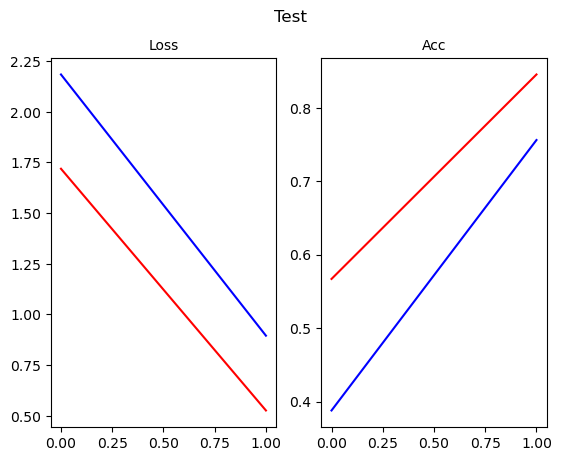

In [6]:
plt.figure()
plt.suptitle('Test', fontsize=12)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(eval_losses, color='r')
ax1.plot(losses, color='b')
ax1.set_title('Loss', fontsize=10, color='black')
ax2 = plt.subplot(1, 2, 2)
ax2.plot(eval_acces, color='r')
ax2.plot(acces, color='b')
ax2.set_title('Acc', fontsize=10, color='black')
plt.show()